In [1]:
# %reload_ext tensorboard
# import os; os.environ['TENSORBOARD_BINARY']='../.new_env/bin/tensorboard'
# %tensorboard --logdir tensorboard/

In [2]:
%reload_ext autoreload
%autoreload 2
from collections import namedtuple
import numpy as np
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling2D, \
                         Dropout, Dense, Input, Concatenate, Flatten
from keras.callbacks import TensorBoard, Callback
from sklearn.preprocessing import LabelEncoder
from avian_vocalizations import data
from avian_vocalizations.visualization import show_sample
from toolbench.tools import print_module_versions
print_module_versions(globals())

Using TensorFlow backend.


             IPython  {'7.9.0'}
               numpy  {'1.17.3'}
               keras  {'2.3.1'}
             sklearn  {'0.21.3'}
 avian_vocalizations  {'0.0.2'}
           toolbench  {'0.0.1'}


In [3]:
index_df, shapes_df, train_df, test_df = data.load_data('../data')
label_encoder = LabelEncoder().fit(index_df['english_cname'] )
n_classes = len(label_encoder.classes_)
X_train = index_df.loc[index_df['test']==False].index.values
y_train = label_encoder.transform(index_df.loc[index_df['test']==False,"english_cname"].values)

In [4]:
class StatusReporter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print('epoch %i, '%epoch, end='')
        for k, v in logs.items(): # accuracy, val_accuracy, loss, val_loss
            if isinstance(v, (np.ndarray, np.generic)):
                print('%s: %s  '%(k, v.item()), end='')
            else:
                print('%s: %s  '%(k, v), end='')
        print()

def ModelFactory(n_classes, n_frames=128, dropout_rate=.2):
    melsg_input = Input(shape=(128,n_frames,1),name='melsg')
    melsg_pathway = Conv2D(16,3,name='melsg_conv2d_1',
                         padding='same',activation="relu")(melsg_input)
    melsg_pathway = MaxPooling2D(pool_size=3,name='melsg_maxpooling_1')(melsg_pathway)
    melsg_pathway = Dropout(rate=dropout_rate,name='melsg_dropout_1')(melsg_pathway)
    melsg_pathway = Conv2D(32,3,padding='same',activation="relu", 
                         name='melsg_conv2d_2')(melsg_pathway)
    melsg_pathway = MaxPooling2D(pool_size=3,name='melsg_maxpooling_2')(melsg_pathway)
    melsg_pathway = Dropout(rate=dropout_rate, name='melsg_dropout_2')(melsg_pathway)
    melsg_pathway = Conv2D(64,3,padding='same',activation="relu", 
                         name='melsg_conv2d_3')(melsg_pathway)
    melsg_pathway = MaxPooling2D(pool_size=2,name='melsg_maxpooling_3')(melsg_pathway)
    melsg_pathway = Dropout(rate=dropout_rate,name='melsg_dropout_3')(melsg_pathway)
    # melsg_pathway = GlobalAveragePooling2D(name='melsg_globalaverage2d')(melsg_pathway)
    melsg_pathway = Flatten()(melsg_pathway)

    mfcc_input = Input(shape=(20,n_frames,1),name='mfcc')
    # Each filter is 20 high, for each of the 20 coefficients (MFCCs)
    mfcc_pathway = Conv2D(64,[20,2],padding='same',
                          name='mfcc_conv2d_1',activation="relu")(mfcc_input)
    mfcc_pathway = MaxPooling2D(pool_size=[1,3],name='mfcc_maxpooling_1')(mfcc_pathway) 
                            # output shape (20, 42, 16)
    mfcc_pathway = Dropout(rate=dropout_rate,name='mfcc_dropout_1')(mfcc_pathway)
    mfcc_pathway = Conv2D(32,[20,1],padding='same',activation="relu",
                          name='mfcc_conv2d_2')(mfcc_pathway)
    mfcc_pathway = MaxPooling2D(pool_size=[1,3],name='mfcc_maxpooling_2')(mfcc_pathway) 
                            # output shape ( 20, 14, 32 )
    mfcc_pathway = Dropout(rate=dropout_rate,name='mfcc_drouout_2')(mfcc_pathway)
    mfcc_pathway = Conv2D(64,[20,1],padding='same',name='mfcc_conv2d_3',
                          activation="relu")(mfcc_pathway)
    mfcc_pathway = MaxPooling2D(pool_size=[1,2],name='mfcc_maxpooling_3')(mfcc_pathway)
                            # output shape( 20, 7, 32 )
    mfcc_pathway = Dropout(rate=dropout_rate,name='mfcc_dropout_3')(mfcc_pathway)
    # mfcc_pathway = GlobalAveragePooling2D(name='mfcc_globalaverage2d',)(mfcc_pathway)
    mfcc_pathway = Flatten()(mfcc_pathway)

    joined = Concatenate(axis=-1,name='joint1')([melsg_pathway, mfcc_pathway])
    joined = Dense(16, name='joined_dense1', activation='relu')(joined)
    joined = Dense(32, name='joined_dense2', activation='relu')(joined)
    joined = Dense(n_classes, activation='softmax', name='joined_output')(joined)

    model = Model([melsg_input, mfcc_input], joined)
    return model

In [5]:
params=dict(n_classes=n_classes, batch_size=4, seed=37, n_frames=128, data_dir="../data")

training_generator = data.AudioFeatureGenerator(X_train[:7], y_train[:7], shuffle=True, **params)
validation_generator = data.AudioFeatureGenerator(X_train[-7:], y_train[-7:], shuffle=False, **params)

## Visualize generated data

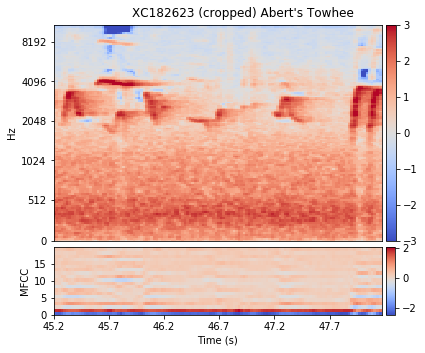

../data/audio/XC182623.mp3


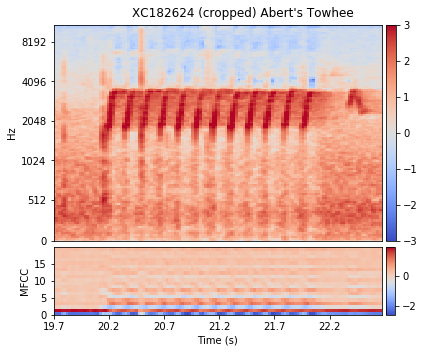

../data/audio/XC182624.mp3


In [6]:
# validation_generator.on_epoch_end()
# validation_generator.seed+=1
Xs, ys = validation_generator[0] # first batch
for i in range(ys.shape[0])[:2]: # 2 samples 
    label = label_encoder.classes_[ys[i]][0]
    show_sample(Xs['melsg'][i], Xs['mfcc'][i], file_id=Xs['id'][i], 
                label='(cropped) '+label, offset=Xs['offset'][i],
                data_dir="../data", load_clip=True )

## Train it

In [7]:
! rm -rf ./tensorboard/new_model
checkpointer = TensorBoard(log_dir="./tensorboard/new_model")
status_reporter = StatusReporter()

model = ModelFactory(n_classes)
# model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
learning = model.fit_generator(
            training_generator, 
            validation_data=validation_generator,
            epochs=n_epochs, 
            steps_per_epoch=len(training_generator),
            validation_steps=len(validation_generator),
            callbacks=[status_reporter, checkpointer], 
            #use_multiprocessing=True, workers=4,
            verbose=0, )
acc_at_min_loss = learning.history['val_accuracy'][np.argmin(learning.history['val_loss'])]
print("min loss: %.5f, accuracy at min loss: %.5f"%(
    np.min(learning.history['val_loss']), acc_at_min_loss ))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



NameError: name 'n_epochs' is not defined